# Logistic Regression - New Labeling and Normalization

This notebook contains the codes for:
1. Training 9 logistic regression models that take as inputs the ticker prices over 9 sampling periods, and predict whether those tickers will become 10 Baggers
2. The trained models are then applied on test datasets over the 9 sampling periods to generate prospect lists, which can be utilized to construst portfolios using different Portfolio Strategies.

Note the tickers in the test datasets are different from thos in the training and validation datasets.

<u>***Logistic Regression Model***</u>  
For a ticker, given a sample period (e.g. 3-1-2009 to 12-31-2015), we train a logistic regression model to to predict it will become a 10 Bagger by 3-31-2019. 

10_bagger = f(x_t_start, x_t_1, ..., x_t_end)
 
where:  
* x_t_start - ticker's normalized price on 3-1-2009 (set to 1.0)
* x_t_end - ticker's normalized price at the end of sample period 

And the equation for price normalization is:
* x_t_j = p_t_j / p_t_start

The labeling scheme is as followed:

y = True if x_t_final > 10.0

where:  
* x_t_final - ticker's normalized price on 3-31-2019

<u>***Train, Validate and Test Pipeline***</u>   
The dataset will be shuffled and split 35-15-50 into training, validation and test datasets. The prospect lists will thus be constructed using only 50% of the active tickers.

1. The models will be training using the training datasets with regularization constant being the hyperparameter.
2. The best models is picked based on results applying the models on the validation datasets.
3. We then apply the best models on the test datasets to generate the prospect lists.


In [1]:
import quandl  # Access to Sharadar Core US Equities Bundle
api_key = '7B87ndLPJbCDzpNHosH3'

import math
import platform

from pylab import rcParams
import numpy as np
from sklearn import linear_model  # package for logistic regression (not using GPU)
import torch
import pandas as pd
from IPython.display import display
import time
import pickle

from utils import *

from datetime import date, datetime, time, timedelta

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))

Python version:  3.6.6
Pytorch version: 1.1.0


## Import Price History of all Tickers 

In [2]:
stockprices = pd.read_csv("stock_price_history.cvs")
prices = stockprices.set_index('date')

In [63]:
label_filenames = ['labels_12-31-2010.csv',
              'labels_12-31-2011.csv',
              'labels_12-31-2012.csv',
              'labels_12-31-2013.csv',
              'labels_12-31-2014.csv',
              'labels_12-31-2015.csv',
              'labels_12-31-2016.csv',
              'labels_12-31-2017.csv',
              'labels_12-31-2018.csv'
             ]

prices_filenames = ['inputs_notfilled_2010-12-31.csv',
            'inputs_notfilled_2011-12-31.csv',
            'inputs_notfilled_2012-12-31.csv',
            'inputs_notfilled_2013-12-31.csv',
            'inputs_notfilled_2014-12-31.csv',
            'inputs_notfilled_2015-12-31.csv',
            'inputs_notfilled_2016-12-31.csv',
            'inputs_notfilled_2017-12-31.csv',
            'inputs_notfilled_2018-12-31.csv'
              ]

# End of sampling periods
end_dates = [
    '2010-12-31',
    '2011-12-30',
    '2012-12-31',
    '2013-12-31',
    '2014-12-31',
    '2015-12-31',
    '2016-12-30',
    '2017-12-29',    
    '2018-12-31'
]

# the date where the final value of the portfolio is tallied
target_date = '2019-03-29' 

In [128]:
def get_price(ticker, date):
    # Get the ticker's price on a specific date. If the ticker has been delisted before 
    # that date, return its price at delisting
    # The function assumes there is a global dataset "prices"
    
    # Make sure date is a valid trading day
    if date not in list(prices.index):
        print('{} is not a trading date!'.format(date))
        return None
    
    price = prices[ticker].loc[date]  # get the ticker's price on that date
    
    if np.isnan(price): 
        # If ticker's price on the date is NaN, it has been delisted
        if debug:
            print('Delisted.')
        # get ticker's price at delisting    
        price = prices[ticker].loc[prices[ticker].last_valid_index()]      
    
    return price

def prepare_dataset(prices_file, labels_file, debug=False):
    # Extract data from file, preprocess and output X, y and combined dataset
    
    # Extract price history data, preprocess to produce X
    X = pd.read_csv(prices_file).set_index('date')   # read from external file, set date as index
    
    first_valid_prices = X.apply(first_valid_idx, axis=0)  # get first valid price for each ticker
    
    # stock price is zero before IPO; stock price is last valid price after delisting
    X = X.fillna(axis=0, method='ffill')  # forward fill along date axis with last valid price
    X = X.fillna(0)  # fill all other NaN with zero - remaining NaN before the first valid price

    # Transpose Dataframe into rows of tickers; normalize price by dividing by ticker's first valid price
    X = X.transpose().div(first_valid_prices, axis=0)
    
    # Import data from old label file, set ticker as index
    y = pd.read_csv(labels_file).set_index('ticker')
    
    if debug:
        for ticker, apprec, first_price in zip(y.index, y['appreciation'], first_valid_prices):
            print(ticker, apprec, first_price)
        display(X)
        display(y)
    
    # Merge X and 10_bagger label into a dataset (for shuffling and splitting later on)
    data = X.merge(y['10bagger'], left_index=True, right_index=True)

    return X, y, data

def shuffle_split_data(data, train_ratio, valid_ratio, test_ratio, debug = False):
    
    if train_ratio+valid_ratio+test_ratio != 1.0:
        print('Train, Valid and Test split ratios does not sum to 1.0!!!')
        return None
    
    # Shuffle the data
    shuffled_data = data.sample(frac=1)

    # Split data into training, validation and test datasets
    train_valid_split = int(len(shuffled_data.index)*train_ratio)
    valid_test_split = int(len(shuffled_data.index)*(train_ratio+valid_ratio))
    
    # price histories
    train_x = shuffled_data.iloc[:train_valid_split,:-1]
    valid_x = shuffled_data.iloc[train_valid_split+1:valid_test_split,:-1]
    test_x = shuffled_data.iloc[valid_test_split+1:,:-1]
    
    # 10_bagger labels
    train_y = shuffled_data.iloc[:train_valid_split,-1]
    valid_y = shuffled_data.iloc[train_valid_split+1:valid_test_split,-1]
    test_y = shuffled_data.iloc[valid_test_split+1:,-1]

    # tickers
    train_tickers = list(train_x.index)
    valid_tickers = list(valid_x.index)
    test_tickers = list(test_x.index)
    
    print('Size of training set; {}'.format(len(train_tickers)))
    print('Size of validation set; {}'.format(len(valid_tickers)))
    print('Size of test set; {}'.format(len(test_tickers)))
   
    return train_x,train_y,train_tickers, valid_x, valid_y, valid_tickers, test_x, test_y, test_tickers
    

## Generate Models

In [131]:
best_models = {}  # For saving best models for each sampling period
test_datasets = {}  # To store X, y and tickers of the test dataset for each sampling period
debug = False

for end_date, label_filename, prices_filename in zip(end_dates, label_filenames, prices_filenames):
    
    print("Sample Period ending {}.".format(end_date))
    v2_label_name = 'v2'+ label_filename
    
    file_prices = "../datasets/sharader/"+prices_filename  # price history of valid tickers in sample period
    file_labels = "../datasets/sharader/"+label_filename  # labels of valid tickers in sample period
    
    # Import raw data from file, preprocess and output X, y and combined dataset
    X_all, y, data = prepare_dataset(file_prices, file_labels, debug=debug)

    # Shuffle the data
    train_x,train_y,train_tickers,valid_x,valid_y,valid_tickers, \
        test_x,test_y,test_tickers = shuffle_split_data(data,0.35,0.15,0.5, debug=debug)
    
    test_datasets[end_date] = (test_x,test_y,test_tickers)  # save test datasets for generating prospects
    
    C_values = [1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 5e-1, 1.0, 10]
    
    best_model = None
    best_prec_100 = 0
    
    # Train log reg models with different regularization constants
    for C in C_values:

        print("Regularization Constant: {}".format(C))

        model = linear_model.LogisticRegression(C=C, class_weight='balanced', max_iter=30000)
        model.fit(train_x, train_y)

        predicts = model.predict(valid_x)
        correct = predicts == valid_y
        
        # Sort labels and scores in descending order of scores
        scores = model.decision_function(valid_x)  # get probability scores
        scores_labels = list(zip(scores, valid_y))  # assemble scores and labels
        scores_labels.sort(reverse = True)   # sort zipped data in descending order of score
        
        sortedlabels = [x[1] for x in scores_labels] # generate sorted labels to calculate Precision@N
        
        # Use precision@100 to determine best model  
        prec_100 = sum(sortedlabels[:100])/100 
        if prec_100 > best_prec_100:
            best_model = model   # save best model

        # Output performance statistics
        TP,FP,TN,FN = calc_metrics(predicts,valid_y)
        print(TP,FP,TN,FN)
        precision, recall, accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)
        print("Accuracy:{:.3f} TPR:{:.3f} TNR:{:.3f} BER:{:.3f}".format(accuracy, TPR, TNR, BER))
        print("Precision:{:.3f} Recall:{:.3f}".format(precision, recall))
        
        # output Precision@N stats
        print("Precision@100: {:.4f}".format(sum(sortedlabels[:100]) / 100))
        print("Precision@50: {:.4f}".format(sum(sortedlabels[:50]) / 50))
        print("Precision@10: {:.4f}".format(sum(sortedlabels[:10]) / 10))
    
        print('\n')
    
    best_models[end_date] = best_model  # save best model for the sampling period


Sample Period ending 2010-12-31.
Size of training set; 2292
Size of validation set; 982
Size of test set; 3274
Regularization Constant: 1e-07
36 83 821 42
Accuracy:0.873 TPR:0.462 TNR:0.908 BER:0.315
Precision:0.303 Recall:0.462
Precision@100: 0.3200
Precision@50: 0.3600
Precision@10: 0.8000


Regularization Constant: 1e-06
41 108 796 37
Accuracy:0.852 TPR:0.526 TNR:0.881 BER:0.297
Precision:0.275 Recall:0.526
Precision@100: 0.3300
Precision@50: 0.3600
Precision@10: 0.8000


Regularization Constant: 1e-05
43 126 778 35
Accuracy:0.836 TPR:0.551 TNR:0.861 BER:0.294
Precision:0.254 Recall:0.551
Precision@100: 0.3300
Precision@50: 0.4000
Precision@10: 0.7000


Regularization Constant: 0.001
45 137 767 33
Accuracy:0.827 TPR:0.577 TNR:0.848 BER:0.287
Precision:0.247 Recall:0.577
Precision@100: 0.3200
Precision@50: 0.4400
Precision@10: 0.5000


Regularization Constant: 0.01
45 138 766 33
Accuracy:0.826 TPR:0.577 TNR:0.847 BER:0.288
Precision:0.246 Recall:0.577
Precision@100: 0.3300
Precision@

56 64 1034 22
Accuracy:0.927 TPR:0.718 TNR:0.942 BER:0.170
Precision:0.467 Recall:0.718
Precision@100: 0.5400
Precision@50: 0.6600
Precision@10: 0.8000


Regularization Constant: 1.0
56 59 1039 22
Accuracy:0.931 TPR:0.718 TNR:0.946 BER:0.168
Precision:0.487 Recall:0.718
Precision@100: 0.5300
Precision@50: 0.6600
Precision@10: 0.8000


Regularization Constant: 10
52 61 1037 26
Accuracy:0.926 TPR:0.667 TNR:0.944 BER:0.194
Precision:0.460 Recall:0.667
Precision@100: 0.5100
Precision@50: 0.6400
Precision@10: 0.6000


Sample Period ending 2015-12-31.
Size of training set; 3046
Size of validation set; 1304
Size of test set; 4351
Regularization Constant: 1e-07
58 65 1159 22
Accuracy:0.933 TPR:0.725 TNR:0.947 BER:0.164
Precision:0.472 Recall:0.725
Precision@100: 0.5100
Precision@50: 0.7800
Precision@10: 0.9000


Regularization Constant: 1e-06
66 85 1139 14
Accuracy:0.924 TPR:0.825 TNR:0.931 BER:0.122
Precision:0.437 Recall:0.825
Precision@100: 0.5400
Precision@50: 0.7600
Precision@10: 0.9000



In [132]:
# Save the best models
f = open("best_models.pkl","wb")
pickle.dump(best_models,f)
f.close()

## Generate Prospect Lists

In [135]:
prospects = {}

for end_date in end_dates:  # for each sampling period
    model = best_models[end_date]
    test_x,_,test_tickers = test_datasets[end_date]
    
    scores = model.decision_function(test_x)  # get probability scores for test dataset
    
    # sort tickers in test dataset in descending order of score
    scores_tickers = list(zip(scores, test_tickers))  
    scores_tickers.sort(reverse = True)
    
    prospects[end_date] = scores_tickers  # save into prospect list
    

In [138]:
prospects['2012-12-31'][:20]

[(4412.9613913955, 'HTLLQ'),
 (1445.6522913659592, 'AICIQ'),
 (244.15391758857956, 'TTNP'),
 (160.28735354526958, 'PXPLY'),
 (155.5422770812629, 'EGHDQ'),
 (147.7122272884991, 'PCYC'),
 (109.10943303046355, 'THNKQ'),
 (63.60801902751476, 'SNTO'),
 (60.19391423583161, 'FSII'),
 (58.04672084348773, 'SRZ'),
 (51.75143238555421, 'ONTO'),
 (51.506811393374605, 'DDD'),
 (50.71062774423063, 'AMRN'),
 (49.01489355916819, 'TRS'),
 (37.51540090340767, 'TEN'),
 (37.142140437064484, 'UAMY'),
 (36.7466198641747, 'VRML'),
 (35.511782883443765, 'VRTS'),
 (33.45088860240168, 'SPRD'),
 (29.762628939020857, 'SMDK')]

In [139]:
# Save prospect lists
f = open("prospects.pkl","wb")
pickle.dump(prospects,f)
f.close()

## Model Coefficients

In [98]:
best_models['2015-12-31'].coef_[0]

array([-0.52446593, -0.35600715,  0.01086778, ...,  1.18685853,
        1.64653729,  2.11668678])

In [105]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

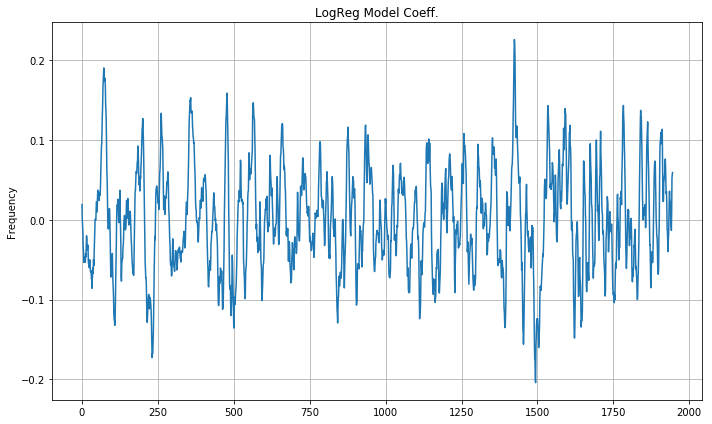

In [119]:
y_raw = best_models['2016-12-30'].coef_[0]

y = movingaverage(y_raw ,30)  # Smooth the coefficents

plt.figure(figsize=(10, 6))
plt.plot(y)
plt.ylabel("Frequency")
plt.title("LogReg Model Coeff.")

plt.grid(True)
plt.tight_layout()

plt.show()

## Stock Chart

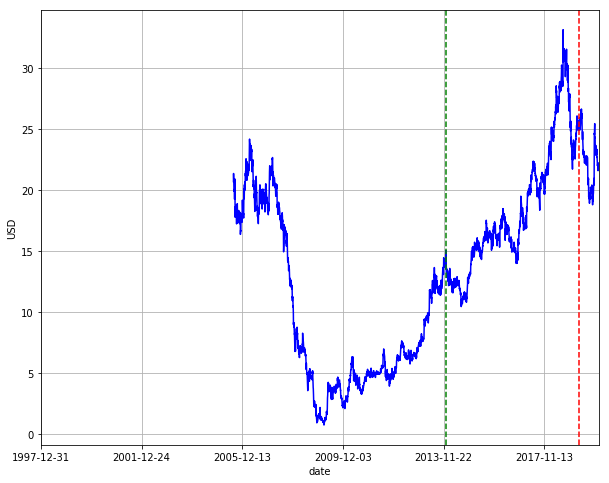

In [117]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ticker = 'RUTH'
ax = prices[ticker].plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.axvline(x=prices[ticker].index.get_loc('2019-03-29'), color="red", linestyle='--')
ax.axvline(x=prices[ticker].index.get_loc('2013-12-31'), color="green", linestyle='--')